# Marine Heat Wave analysis
The purpose of this notebook is to take in SST data, along with previously computed climatology and threshold, process these and output all the MHW events that occur in the data

First, we import the data and required modules. 

In [1]:
import xarray as xr
import pandas as pd
import now
import numpy as np
import dask as da
import scipy.ndimage as ndimage
import seaborn as sns
import time
import cartopy.crs as ccrs
import dask_image.ndmeasure
from datetime import date
from matplotlib import pyplot as plt
from dask.distributed import LocalCluster, Client
from cartopy import config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rcParams["figure.figsize"] = [16,9]
sns.set()
cluster = LocalCluster(processes=False, local_dir= "/g/data1a/e14/rm6294/dask-workers")
client = Client(cluster)
client

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: inproc://10.0.64.17/3390/1 Dashboard: http://localhost:34184/status,Cluster Workers: 1 Cores: 8 Memory: 33.67 GB


In [3]:
# Opens Climatology and MHW SST threshold files, that have been created before.
# Note: p stands for past, f for future
localDir = "/g/data1a/e14/rm6294/NOWMHW/"
pThresh = xr.open_dataarray(localDir + 'pastThreshRep.nc')
pClim = xr.open_dataarray(localDir + 'pastClimRep.nc')
fThresh = xr.open_dataarray(localDir + 'futureThreshRep.nc')
fClim = xr.open_dataarray(localDir + 'futureClimRep.nc')

In [8]:
# Opens NOW SST data, from which we need the SST.
sst_dir = '/g/data1a/e14/gs9353/NOW_OUTPUTS/'
sstFut = xr.open_zarr(sst_dir + 'now_cordex24_BMJv2_BILAP_ALL/cordex24-BMJv2_BILAP_ALL_1d_1990_2008_grid_T_2D.zarr')['tos'].sel(simulation = 'Future') #tos means sst
sstPast = xr.open_zarr(sst_dir + 'now_cordex24_BMJv2_BILAP_old/cordex24-BMJv2_BILAP_1d_1990_2008_grid_T_2D.zarr')['tos'].sel(simulation = 'Present')

## Looking for MHW
The method we will be using to identify MHW is to:
* Create a mask on top of the data, which has a binary True/False representing whether the sst at the location is above the corressponding threshold. 
    * Using the mask, try and find consecutive days where the threshold is crossed, as these represent the MHW.
* Once we have all the SSTs that cross the threshold, we will the apply the duration requirement, and look for SSTs that cross the threshold for 5 consecutive days

### Creating a Mask (Crossing the threshold)
We are looking for SST to cross the threshold. We will do this by:
* Subtracting the background climatology from both the threshold and sst, giving us theshold anomaly (thresha) and SST anomaly (ssta).
* Dividing ssta by thresha.
* Saving the severity data, so we can simply call it for use in the animation section.
This process will not only give us a matrix of threshold crosses (as ssta > thresha at this points, ssta/thresa > 1), but also tell us about the severity of the MHW, as temperatures 2 thresholds away from the background will be represented with a two in the matrix and so on.

##### Note: Current looking at Future SSTs compared to a past Clim.

In [11]:
# Finding thresha and ssta
thresha = pThresh.chunk({'x':50, 'y':50, 'time_counter':365}) - pClim.chunk({'x':50, 'y':50, 'time_counter':365})
ssta = sstFut.chunk({'x':50, 'y':50, 'time_counter':365}) - pClim.chunk({'x':50, 'y':50, 'time_counter':365})

In [12]:
mhws = xr.where(ssta > thresha, ssta/thresha, 0)
# The next line removes any points that were made very large due to epsilon error in the ssta/thresha div
mhws = xr.where(mhws > 10, 0, mhws)

mhws['nav_lon'] = mhws['nav_lon'] % 360 

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


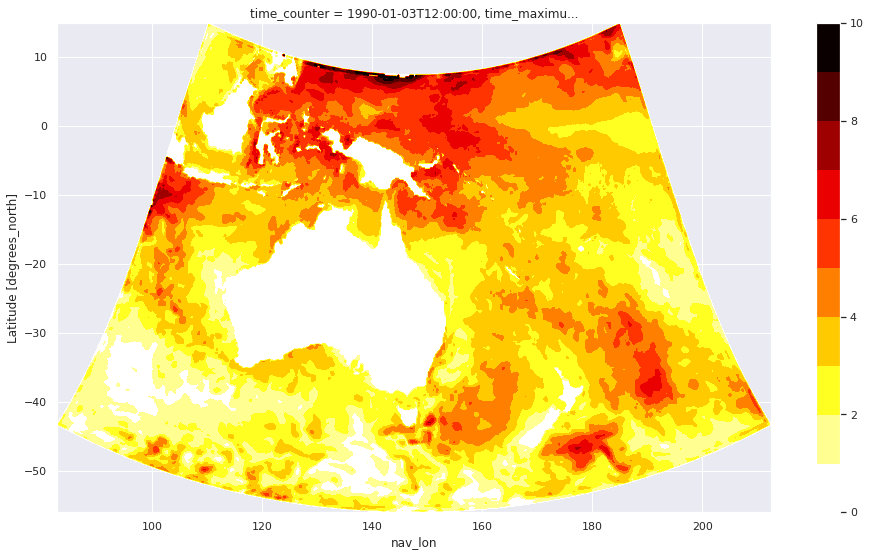

In [21]:
mhws.isel(time_counter = 2).plot.contourf(x='nav_lon', y='nav_lat', cmap = 'hot_r',vmin = 0, vmax = None, levels = arange(0,11));
#plt.savefig("/g/data1a/e14/rm6294/NOWMHW/MHWPlots/" + 'mhwPlot_{:0>3d}.png'.format(i),bbox_inches='tight')

## Checking for duration
We now have all the SSTs that cross our threshold. This section will aim to find the events that meet the 5 consecutive days with at most a 2 day gap criterion. To do this we will:
* For each time series, track how long each MHW occurs for.
* Eliminate those that are less than 5 days long 

In [22]:
def duration(severity, join_gaps = True):
    # Finding the dates considered in severity & converting it to nanoseconds
    mhw_dates = pd.to_numeric(severity['time_counter'])
    # Creates mhw_dur object which has a time series (in nanoseconds) at each grid point
    mhw_dur = xr.broadcast(severity, mhw_dates)[1]
    mhw_dur.data = da.array.from_array(mhw_dur.data, chunks = chunk_size)
    
    lbl = da.array.map_blocks(remove_false_events, mhw_dur.data, severity.data, dtype = 'float')
    
    return xr.where(lbl > 0, severity, 0)

In [23]:
def day2ns(days):
    # Converts days to nanoseconds. Days -> Hours -> Seconds -> nanoseconds 
    return int(days * 24 * 3600 * 1e9)

In [24]:
def remove_false_events(mhw_dur, severity, minDur = 5):
    struc = np.zeros((3,3,3))
    # Looking for consecutive SST threshold crosses for only the time dimension:
    struc[:,1,1] = 1
    labeled_array, num_features = ndimage.label(severity, structure = struc)   
    indexs = da.array.arange(1, num_features + 1)
   
    # Calculates the max and min time points for all labeled points, i.e. the beggining and end dates for SST events 
    maxMHW = ndimage.maximum(mhw_dur, labels=labeled_array, index=indexs)
    minMHW = ndimage.minimum(mhw_dur, labels=labeled_array, index=indexs)

    # Calculates the length of all potential MHW events.
    dur = maxMHW - minMHW + day2ns(1) 

    # converting minDur (default = 5) days to nanoseconds
    minDur_ns = day2ns(minDur) 

    # Finds the event numbers of MHWs with duration < minDur_ns.
    # Adding 1 so that event number matches with value in labeled_array. 
    failed_ev_num = da.array.where(dur < minDur_ns)[0]  + 1 
    failed_ev_num = failed_ev_num.compute()

    # objs has the location of each labeled event 
    # i.e objs[0] is the location of the event 1, objs[10] location of event 11 and so on.
    objs = ndimage.find_objects(labeled_array.astype('int'))
    
    # failed_objs has the location for all the failed events in labeled_array 
    failed_objs = [objs[i - 1] for i in failed_ev_num]
    # Removes all the places where we had a failed MHW
    for loc in failed_objs:
        labeled_array[loc] = 0

    return labeled_array

In [29]:
chunk_size = 431 # <- Chunk size needs to be the same as the max spatial dimension length 
mhws = mhws.chunk({'time_counter' : chunk_size})

In [35]:
 mhws_max_sev = mhws.chunk({'x' : 120, 'y' : 90, 'time_counter' : 365}).groupby('time_counter.year').max(dim = 'time_counter').mean(dim = 'year').compute()

In [36]:
mhws_max_sev = xr.where(mhws_max_sev == 0, np.nan, mhws_max_sev)

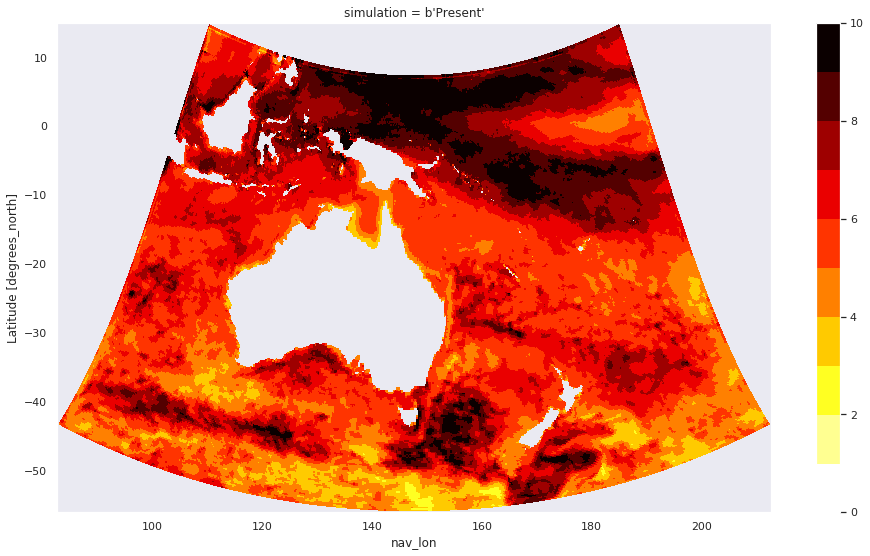

In [45]:
levels = arange(0, 11)
mhws_max_sev.plot(cmap = 'hot_r', x = 'nav_lon', y = 'nav_lat', levels = levels)

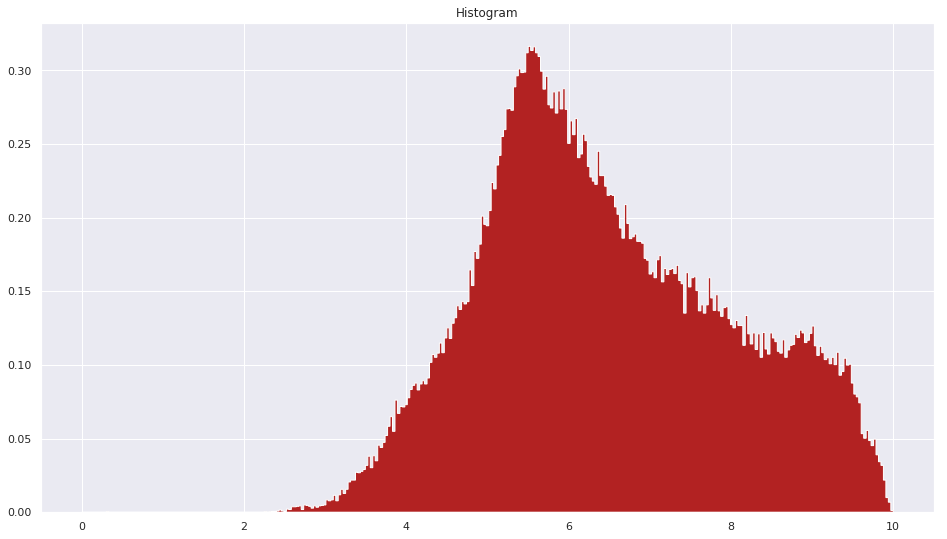

In [52]:
mhws_max_sev.plot.hist(bins = linspace(0,10, 330),  histtype='stepfilled', color = 'firebrick', density=True);

In [53]:
# Assigns a 1 for every mhw day, and sums along time dimension to calculate # of MHW days at each grid point.
pastDays = xr.where(mhws > 1, 1, 0).sum('time_counter')
#Removes areas where the sum receives 0, i.e. where there are no MHW days ever. This is should be all land.
pastDays = xr.where(pastDays == 0, np.nan, pastDays).compute()
pastDays = pastDays/19

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


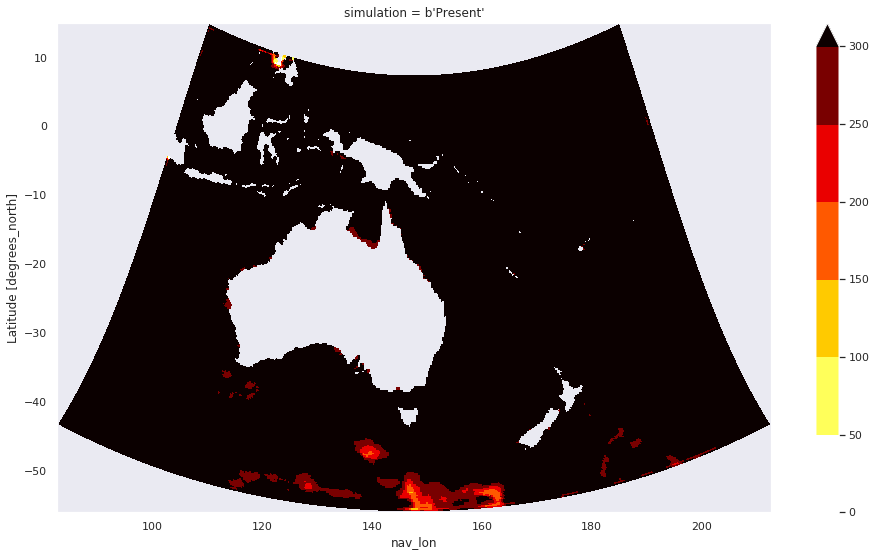

In [70]:
pastDays.plot(cmap = 'hot_r', x = 'nav_lon', y = 'nav_lat', levels = arange(0,350, 50));

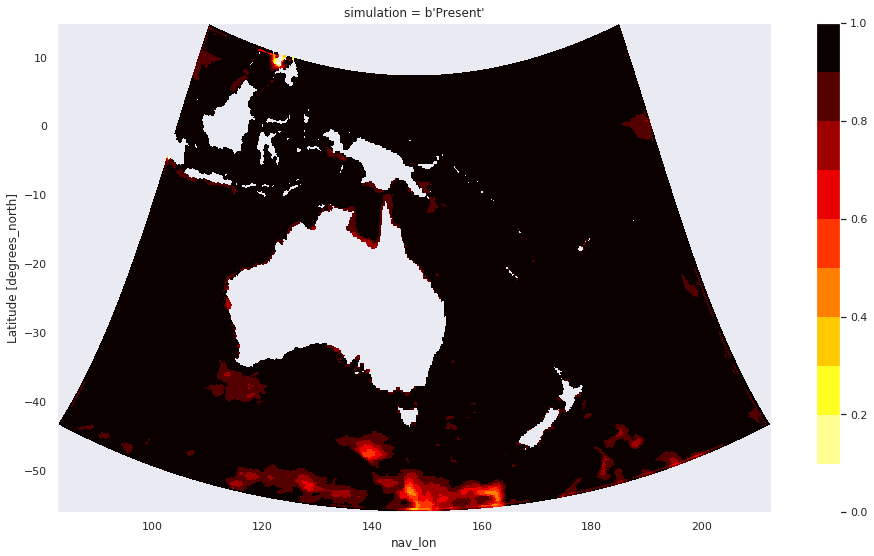

In [69]:
(pastDays/366).plot(cmap = 'hot_r', x = 'nav_lon', y = 'nav_lat', levels = linspace(0,1, 11));

In [30]:
mhw_preGap = duration(mhws)

In [32]:
mhw_preGap = mhw_preGap.compute()

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
distributed.worker - WARNING -  Compute Failed
Function:  execute_task
args:      ((subgraph_callable, (subgraph_callable, array([[[1227009600000000000, 1227009600000000000, 1227009600000000000,
         ..., 1227009600000000000, 1227009600000000000,
         1227009600000000000],
        [1227009600000000000, 1227009600000000000, 1227009600000000000,
         ..., 1227009600000000000, 1227009600000000000,
         1227009600000000000],
        [1227009600000000000, 1227009600000000000, 1227009600000000000,
         ..., 1227009600000000000, 1227009600000000000,
         1227009600000000000],
        ...,
        [1227009600000000000, 1227009600000000000, 1227009600000000000,
         ..., 1227009600000000000, 1227009600000000000,
         1227009600000000000],
        [1227009600000000000, 1227009600000000000, 1227

ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [27]:
%%time
mhw_preGap.chunk({'x': 431, 'y': 289, 'time_counter': 431}).to_netcdf("/g/data1a/e14/rm6294/NOWMHW/severityMHWNOW_futSSTPastClim.nc")

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
distributed.worker - WARNING -  Compute Failed
Function:  execute_task
args:      ((subgraph_callable, (subgraph_callable, array([[[631195200000000000, 631195200000000000, 631195200000000000,
         ..., 631195200000000000, 631195200000000000,
         631195200000000000],
        [631195200000000000, 631195200000000000, 631195200000000000,
         ..., 631195200000000000, 631195200000000000,
         631195200000000000],
        [631195200000000000, 631195200000000000, 631195200000000000,
         ..., 631195200000000000, 631195200000000000,
         631195200000000000],
        ...,
        [631195200000000000, 631195200000000000, 631195200000000000,
         ..., 631195200000000000, 631195200000000000,
         631195200000000000],
        [631195200000000000, 631195200000000000, 631195200000000000,
         .

ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [32]:
%debug

> /g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/numpy/lib/stride_tricks.py(193)_broadcast_shape()
    191     # use the old-iterator because np.nditer does not handle size 0 arrays
    192     # consistently
--> 193     b = np.broadcast(*args[:32])
    194     # unfortunately, it cannot handle 32 or more arguments directly
    195     for pos in range(32, len(args), 31):

ipdb> *args[:32}
*** SyntaxError: invalid syntax
ipdb> *args[:32]
*** SyntaxError: can't use starred expression here
ipdb> b
ipdb> u
> /g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/numpy/lib/stride_tricks.py(259)broadcast_arrays()
    257     args = [np.array(_m, copy=False, subok=subok) for _m in args]
    258 
--> 259     shape = _broadcast_shape(*args)
    260 
    261     if all(array.shape == shape for array in args):

ipdb> u
> /g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/scipy/ndimage/measurements.py(776)_sele

ipdb> d
> /g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/scipy/ndimage/measurements.py(994)maximum()
    992 
    993     """
--> 994     return _select(input, labels, index, find_max=True)[0]
    995 
    996 

ipdb> u
> <ipython-input-22-c8d641256265>(9)remove_false_events()
      7 
      8     # Calculates the max and min time points for all labeled points, i.e. the beggining and end dates for SST events
----> 9     maxMHW = ndimage.maximum(mhw_dur, labels=labeled_array, index=indexs)
     10     minMHW = ndimage.minimum(mhw_dur, labels=labeled_array, index=indexs)
     11 

ipdb> mhw_dur.attrs
*** AttributeError: 'numpy.ndarray' object has no attribute 'attrs'
ipdb> mhw_dur.shape(
*** SyntaxError: unexpected EOF while parsing
ipdb> mhw_dur.shape()
*** TypeError: 'tuple' object is not callable
ipdb> shape(mhw_dur)
(431, 289, 431)
ipdb> shape(labeled_array)
(431, 50, 50)
ipdb> shape(index)
*** NameError: name 'index' is not defined
ipdb> shape(indexs

## Joining across Gaps
** TO BE DONE **

# Trials

#### Here, we try and try a solution to implement the duration definiton for MHWs. 
We will use a subset of the dataset to do this. Our approach will consider the time series at each grid point and calculate the duration for of consecutive MHW events. If the duration is less than 5 days, we will set it to zero.

In [166]:
localDir = "/g/data1a/e14/rm6294/NOWMHW/"
mhws = xr.open_dataarray(localDir + 'severityMHWNOW_futRun.nc')
chunk_size = 400
mhws = mhws.chunk({'time_counter' : chunk_size})
# Creating subset
mhwSub = mhws.isel(x = slice(0,400))#,y = slice(0,200))

In [167]:
mhwSub

<xarray.DataArray (time_counter: 6940, y: 289, x: 400)>
dask.array<shape=(6940, 289, 400), dtype=float64, chunksize=(400, 289, 400)>
Coordinates:
    nav_lat          (y, x) float32 dask.array<shape=(289, 400), chunksize=(289, 400)>
    nav_lon          (y, x) float32 dask.array<shape=(289, 400), chunksize=(289, 400)>
  * time_counter     (time_counter) datetime64[ns] 1990-01-01T12:00:00 ... 2008-12-31T12:00:00
    time_maximum_1d  (time_counter) datetime64[ns] dask.array<shape=(6940,), chunksize=(400,)>
    time_minimum_1d  (time_counter) datetime64[ns] dask.array<shape=(6940,), chunksize=(400,)>
    simulation       |S7 ...
Dimensions without coordinates: y, x

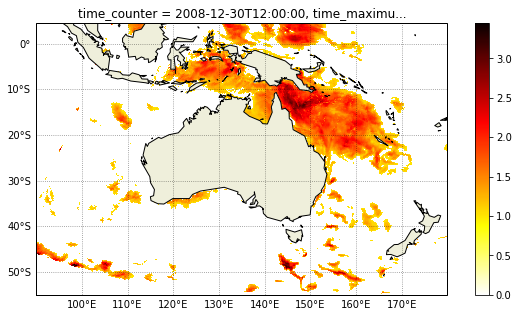

In [171]:
# Plot shows approximately what area we are considering.
ax = plt.subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
now.plot.add_map(lon_min = 90, lon_max = 180, lat_min = -55,ax = ax, lat_max = 4.5)
mhwSub.isel(time_counter = -2).plot(x = 'nav_lon', y = 'nav_lat', cmap = 'hot_r', ax = ax);

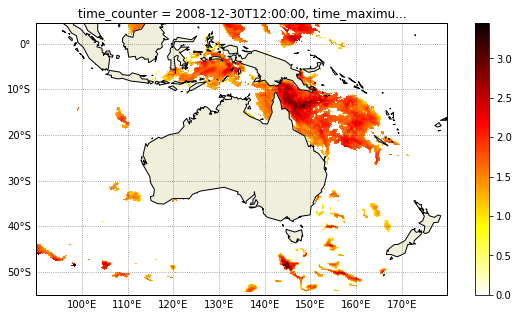

In [172]:
# Plot shows approximately what area we are considering.
ax = plt.subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
now.plot.add_map(lon_min = 90, lon_max = 180, lat_min = -55,ax = ax, lat_max = 4.5)
mhw_preGap.isel(time_counter = -2).plot(x = 'nav_lon', y = 'nav_lat', cmap = 'hot_r', ax = ax);

In [173]:
(mhwSub != mhw_preGap).sum().compute()

<xarray.DataArray ()>
array(17899629)
Coordinates:
    simulation  |S7 b'Future'

#### Function approach
Creating a function that will take a small part of our dataset and return a dataset of the shape with the days removed

In [6]:
def day2ns(days):
    # Converts days to nanoseconds. Days -> Hours -> Seconds -> nanoseconds
    return int(days * 24 * 3600 * 1e9)

In [7]:
def duration(mhw_dur, severity):
    t_chunks = 100
    struc = np.zeros((3,3,3))
    # Just looking for consecutive SST threshold crosses in the time dimension:
    struc[:,1,1] = 1
    labeled_array, num_features = ndimage.label(severity, structure = struc)
        
    #lbl = xr.DataArray(labeled_array, dims=mhw_dur.dims, coords=mhw_dur.coords).chunk({'time_counter': t_chunks})
    indexs = da.array.arange(1, num_features + 1)
   
    # Calculates the max and min time points for all labeled points. I.e. the beggining and end dates for SST events 
    maxMHW = ndimage.maximum(mhw_dur, labels=labeled_array, index=indexs)
    minMHW = ndimage.minimum(mhw_dur, labels=labeled_array, index=indexs)

    # Calculates the length of all potential MHW events.
    dur = maxMHW - minMHW + day2ns(1) 

    # converting minDur (default = 5) days to nanoseconds
    minDur = 5 # default ^. Will probably get passed a value in the full implementation.
    minDur_ns = day2ns(minDur) 

    # Finds the event numbers of MHWs with duration >= minDur_ns.
    # Adding 1 so that event number matches with value in labeled_array. 
    failed_ev_num = da.array.where(dur < minDur_ns)[0]  + 1 
    failed_ev_num = failed_ev_num.compute()

    # objs has the location of each labeled event 
    #i.e objs[0] is the location of the event 1, objs[10] location of event 11 and so on.
    objs = ndimage.find_objects(labeled_array.astype('int'))
    # failed_objs has the location for all the failed events in labeled_array 
    failed_objs = [objs[i - 1] for i in failed_ev_num]
    #lbl = lbl.compute()
    for loc in failed_objs:
        labeled_array[loc] = 0

    return labeled_array

In [162]:
def duration_X(mhw):
    # Converting from date-time to nanoseconds
    mhw_dates = pd.to_numeric(mhw['time_counter'])
    # Creates mhw_dur object which has a time series (in nanoseconds) at each grid point
    mhw_dur = xr.broadcast(mhw, mhw_dates)[1]
    mhw_dur.data = da.array.from_array(mhw_dur.data, chunks = chunk_size)
    
    lbl = da.array.map_blocks(duration, mhw_dur.data, mhw.data, dtype = 'float')
    
    return xr.where(lbl > 0, mhw, 0)

In [169]:
%%time
mhw_preGap = duration_X(mhwSub)

CPU times: user 12.4 s, sys: 2.41 s, total: 14.8 s
Wall time: 13.5 s


In [170]:
%%time
mhw_preGap = mhw_preGap.compute()

distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 2min 38s, sys: 2min 57s, total: 5min 36s
Wall time: 1min 34s


In [85]:
%debug

> /g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/numpy/lib/stride_tricks.py(193)_broadcast_shape()
    191     # use the old-iterator because np.nditer does not handle size 0 arrays
    192     # consistently
--> 193     b = np.broadcast(*args[:32])
    194     # unfortunately, it cannot handle 32 or more arguments directly
    195     for pos in range(32, len(args), 31):

ipdb> U
*** NameError: name 'U' is not defined
ipdb> u
> /g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/numpy/lib/stride_tricks.py(259)broadcast_arrays()
    257     args = [np.array(_m, copy=False, subok=subok) for _m in args]
    258 
--> 259     shape = _broadcast_shape(*args)
    260 
    261     if all(array.shape == shape for array in args):

ipdb> u
> /g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/scipy/ndimage/measurements.py(776)_select()
    774 
    775     # ensure input and labels match sizes
--> 776     in

(138588,)
ipdb> mhw_dur.sha[e
*** SyntaxError: unexpected EOF while parsing
ipdb> mhw_dur.shape
(200, 200, 200)
ipdb> q


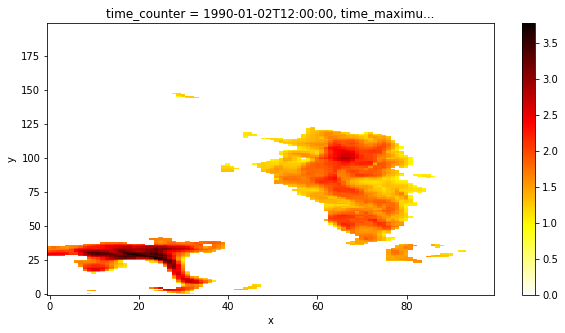

In [72]:
mhw_preGap.isel(time_counter = 1).plot(cmap = 'hot_r')

#### Date approach

In [7]:
struc = np.zeros((3,3,3))
# Just looking for consecutive SST threshold crosses in the time dimension:
struc[:,1,1] = 1
labeled_array, num_features = dask_image.ndmeasure.label(mhwSub.data, structure = struc)
#ndimage.label(mhwSub.data, structure = struc)

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask_image/ndmeasure/__init__.py:214: RuntimeWarning: ``input`` does not have 1 chunk in all dimensions; it will be consolidated first
  warn("``input`` does not have 1 chunk in all dimensions; it will be consolidated first", RuntimeWarning)


In [24]:
# Converting from date-time to nanoseconds
mhw_dates = pd.to_numeric(mhwSub['time_counter'])

# Creates mhw_dur object which has a time series (in nanoseconds) at each grid point
mhw_dur = xr.broadcast(mhwSub, mhw_dates)[1]

In [9]:
# Creating an xarray object with the same coordinates as mhws for labeled_array
lbl = xr.DataArray(labeled_array, dims = mhw_dur.dims, coords = mhw_dur.coords)

In [10]:
# Sets all points in mhw_dur where SST didn't cross threshold to 0. Might be useless, as we don't actually use mhw_dur
mhw_dur = xr.where(lbl > 0, mhw_dur, 0)  

In [26]:
indexs = da.array.arange(1, 1 + num_features)

NameError: name 'num_features' is not defined

In [ ]:
print("mhw_dur: type =", type(mhw_dur.data), ", chunks =", mhw_dur.data.chunksize)
print("    lbl: type =", type(lbl.data), ", chunks =", lbl.data.chunksize)
print(" mhwSub: type =", type(mhwSub.data), ", chunks =", mhwSub.data.chunksize)

In [13]:
# Calculates the max and min time points for all labeled points. I.e. the beggining and end dates for SST events 
maxMHW = dask_image.ndmeasure.maximum(mhw_dur, labels=lbl, index=indexs)
minMHW = dask_image.ndmeasure.minimum(mhw_dur, labels=lbl, index=indexs)

In [14]:
maxMHW = maxMHW.compute()
minMHW = minMHW.compute()

In [16]:
# Calculates the length of all potential MHW events.
dur = maxMHW - minMHW + day2ns(1) 

In [17]:
# converting minDur (default = 5) days to nanoseconds
minDur = 5 # default ^
minDur_ns = day2ns(minDur) 
# Finds the event numbers of MHWs with duration >= minDur_ns. 
failed_ev_num = da.array.where(dur < minDur_ns)[0]  + 1 # Adding 1 so that event number matches with value in labeled_array. 

In [21]:
failed_ev_num = failed_ev_num.compute()

In [19]:
# objs has the location of each labeled event 
#i.e objs[0] is the location of the event 1, objs[10] location of event 11  
objs = ndimage.find_objects(lbl.astype('int'))

In [22]:
# failed_objs has the location for all the failed events in labeled_array 
failed_objs = [objs[i - 1] for i in failed_ev_num]

In [35]:
lbl = lbl.compute()

In [36]:
for loc in failed_objs:
    lbl[loc] = 0

In [37]:
%%time
mhw_preGap = xr.where(lbl > 0, mhwSub, 0)

CPU times: user 678 ms, sys: 102 ms, total: 780 ms
Wall time: 675 ms


In [42]:
# Checks if there are the right amount of locations
print(len(failed_ev_num))
len(failed_objs) == len(failed_ev_num) 

3943


True

In [ ]:
copy = xr.open_dataarray(localDir + 'severityMHWNOW_futRun.nc').isel(x = slice(170,270),y = slice(0,100))
#copy = copy.chunk({'x': 50, 'y': 50})

In [ ]:
#f, (ax1, ax2) = plt.subplots(1, 2)
ax1 = plt.subplot(211, projection=ccrs.PlateCarree(central_longitude=0))
ax2 = plt.subplot(212, projection=ccrs.PlateCarree(central_longitude=0))

now.plot.add_map(lon_min = 90, lon_max = 180, lat_min = -55,ax = ax1, lat_max = 4.5)
mhw_preGap.isel(time_counter = 6935).plot(x = 'nav_lon', y = 'nav_lat', cmap = 'hot_r', ax = ax1);

now.plot.add_map(lon_min = 90, lon_max = 180, lat_min = -55,ax = ax2, lat_max = 4.5)
copy.isel(time_counter = 6935).plot(x = 'nav_lon', y = 'nav_lat', cmap = 'hot_r', ax = ax2);

In [ ]:
copy.isel(x = 1, y = 1).plot()
mhw_preGap.isel(x = 1, y = 1).plot();

In [ ]:
# Check to see if something has actually changed
(mhw_preGap != copy).sum().compute()

#### Now need to calculate gaps

In [ ]:
ev_nums = np.where(dur >= minDur_ns)[0]  + 1

In [ ]:
ev_nums[0:20] - 1 #<- index when counting from 0 

In [ ]:
# Shows the maximum and minimum date for the <index> MHW 
index = 73
print(pd.to_datetime(minMHW[index], unit = 'ns'), pd.to_datetime(maxMHW[index], unit = 'ns'), pd.to_timedelta(dur[index]))

Method:
* Calculate start and end dates for each mhw using min and max function (should already be done from before
* Perform the following calculation `maxMHW[1:] - minMHW[0:-1]`, which calculates the distance between concurrent events
* `np.where(gaps <= day2ns(2))` will calculate which events need to be joined.

Problem: This method relies on concurrent methods being along the same axis. Label is calculated at each time step spatially, which stuffs this up. Might be a easy fix for this, such as changing the order of the dimensions?

In [ ]:
gaps = maxMHW[1:] - minMHW[0:-1]

In [ ]:
np.where(gaps <= day2ns(2))

In [ ]:
#pd.to_datetime(maxs, unit = 'ns')

#### Cobbled Together

In [ ]:
def whereIs(array, ev_num):
    # Finds location of event <ev_num> in array
    return np.where(array == ev_num)[0]

In [ ]:
def clear(array, loc):
    # Removes SST events in array at specified location loc
    array[loc] = 0
    return array

In [ ]:
def duration(array, num_events):
    # Takes in a time-series and implements the 5 day requirement for it.
    min_duration = 5
    for ev in range(1, num_events + 1):
        loc = whereIs(array, ev)
        if len(loc) < min_duration:
            array = clear(array, loc)
    return array

In [ ]:
struc = np.zeros((3,3,3))
struc[:,1,1] = 1
labeled_array1, num_features1 = ndimage.label(mhws.data, structure = struc)

In [ ]:
%%time
labeled_array, num_features = da.array.apply_along_axis(ndimage.label, mhws.get_axis_num('time_counter'), mhws.data).compute()

In [ ]:
# Storing number of events as an integer
numEv = xr.DataArray(num_features.astype('int'), dims = ('x', 'y'))

In [ ]:
%%time
for x in range(0, 430):
    for y in range(0, 288):
        duration(labeled_array[y,x], numEv.isel(x = x, y = y).data)

In [ ]:
mhws_dur = mhws_dur.chunk({'x' : 50, 'y'  : 50})

In [ ]:
mhws_dur = xr.full_like(mhws, labeled_array1)

In [ ]:
labeled_array, num_features = da.array.apply_along_axis(ndimage.label, mhwSub.get_axis_num('time_counter'), mhwSub.data)

In [ ]:
%%time
labeled_array = labeled_array.compute()
num_features = num_features.compute()

In [ ]:
# Checking if we can store labeled_array as an xarray object
numEv = xr.DataArray(num_features.astype('int'), dims = ('x', 'y'))

In [ ]:
%%time
for x in range(0, 50):
    for y in range(0, 50):
        duration(labeled_array[x,y], numEv.isel(x = x, y = y).data)

In [ ]:
l,ne = ndimage.label(mhwSub.isel(x = 0, y = 0))

In [ ]:
ne

In [ ]:
plot(l, label = 'all')
plot(labeled_array[0,0], label = 'real')
plt.legend();

plt.xlim(1000,2000)

In [ ]:
def whereIs(array, ev_num):
    # Finds location of event <ev_num> in array
    return np.where(array == ev_num)[0]

In [ ]:
def check(array, loc):
    # Removes SST events in array at specified location loc
    array[loc] = 0
    return array

In [ ]:
def duration(array, num_events):
    # Takes in a time-series and implements the 5 day requirement for it.
    min_duration = 5
    for ev in range(1, num_events + 1):
        loc = whereIs(array, ev)
        if len(loc) < min_duration:
            array = check(array, loc)
    return array

    '''
       # Maybe make it recursive?? 
    
    duration(array, num_events, index)
    if index < num_events:
        loc = da.delayed(whereIs)(array, ev)
        array = da.delayed(check)(array, loc)
        da.delayed(duration)(array, num_events, index + 1)
    else:
        return array
    '''

In [ ]:
checked[:,0,0]  = 0

In [ ]:
labeled_array, num_features = da.array.apply_along_axis(ndimage.label, mhwSub.get_axis_num('time_counter'), mhwSub.data)
checked = (np.zeros_like(mhwSub)).astype('object')


for x in range(0, 50):
    for y in range(0, 50):
        checked[:,x,y] = da.delayed(duration, pure = True)(labeled_array[x,y], num_features[x,y], 0)


In [ ]:
plot(a)
plot(labeled_array[0,0]);

In [ ]:
'''
def check(length, min_duration):
    # Checks if length of event is greater than the min duration required
    return (length < min_duration)

def clear(array, loc):
    # Removes SST events in array at specified location loc
    array[loc] = 0
    return array
'''

In [ ]:
np.where(calc[0,0] == num_features[0,0])

In [ ]:
# Sample for how the algorigthm will look. Problem is, we have to iterate i & j & num_events. Gonna look into 
# dask.delayed to try and loop through this.
new = []
i = 0; j = 0; num_events = num_features[i,j];
for ev in range(1, num_events):
    loc = da.delayed(whereIs)(calc[i,j], ev)
    new = da.delayed(check)(calc[i,j], loc)

In [ ]:
num_features = num_features.astype('int')

In [ ]:
%%time

'''
Currently: This algorithm finds events with duration less than 5, and sets the values to 0.
It has the capability to identify events that will occur two days later, but can't yet link them up. 
Additionally, there is no parralelisation capability - which is the whole point of this thing. Might be worht
looking at the percentile application to look into parralelisation.
'''


a = num_features
for i in range(1,num_features):
    loc = np.where(labeled_array == i)
    dur = loc[0][-1] - loc[0][0] + 1
    if dur < 5:
        a -= 1
        labeled_array[loc] = 0
    elif labeled_array[loc[0][-1] + 1, loc[1][-1], loc[2][-1]] != 0:
        print('Conection!')
        print(i)
        
print('Found', num_features - a, 'false events')

### Trying to spatially connect MHWs and then calculate the duration connected events.  
Currently links events that are spatially and/or temporally connected, but doesn't change original dataset.

In [ ]:
%%time
mhwSub = mhwSub.chunk({'time_counter':10})
# Structure such that diagonal connections in both spatial and temporal dimensions are counted. 
struc = np.ones((3,3,3)) 
# This function finds strings of consecutive nonzero numbers. 
labeled_array, num_features = ndimage.label(mhwSub, struc)

In [ ]:
num_features

In [ ]:
%%time
# Brute force approach. Looping through each of the labelled events, and calculating their duration
feat = num_features
for i in range(1, num_features):
    time = np.where(labeled_array == i)[0]
    dur = time[-1] - time[0] + 1
    if dur < 5:
        feat -= 1
        
print("# MHWs originally:", num_features, "\n # MHWs after duration constraint: ", feat)

In [ ]:
# Get the time record and broadcast its shape to be 3D using xarray.broadcast
time_record = xr.broadcast(mhwSub.isel(x=1,y=1),mhwSub.isel(x=1,y=1), mhwSub.isel(x=1,y=1))

In [ ]:
 b

In [ ]:
np.where(labeled_array == 11)
#print(len(I))
#print(I,J,K, sep = '\n')

In [ ]:
%%time
I, J, K = np.where(labeled_array == 9)

labeled_array[(I,J,K)] = 0
print(labeled_array[(I,J,K)])#.isel(time_counter = 2).plot()

In [ ]:
index = 14
matshow(mhwSub[index], origin = 'lower');
matshow(labeled_array[index],origin='lower');

In [ ]:
maxs = ndimage.maximum(mhwSub.isel(x=0,y=0), labels = labeled_array[:,0,0], index=np.arange(1, num_features + 1))
mins = ndimage.minimum(mhwSub.isel(x=0,y=0), labels = labeled_array[:,0,0], index=np.arange(1, num_features + 1))

In [ ]:
#mhwSub.isel(x=0,y=0).plot()
plot(maxs)
plot(mins)
xlim(3800,3840);

In [ ]:
maxs = pd.to_datetime(maxs, unit = 'ns')
mins = pd.to_datetime(mins, unit = 'ns')
plot(maxs)
plot(mins)

In [ ]:
dif = maxs - mins

In [ ]:
dif

In [ ]:
matshow(labeled_array[0], origin = 'lower');

In [ ]:
index = 3824
print(maxs[index], mins[index])

In [ ]:
shape(mins)

In [ ]:
durations = maxs - mins

In [ ]:
print('1', durations[2])

#### First, we will try with a subset of the entire dataset.
This subset will focus on the past data.

In [ ]:
# Creating subset:
# key: p = past, f = fast, c = clim, t = threshold 
pcSub = pClim.isel(x = slice(220,320),y = slice(50,150))
ptSub = pThresh.isel(x = slice(220,320),y = slice(50,150))
sstSub = sstPast.isel(x = slice(220,320),y = slice(50,150))

In [ ]:
# Showing that we have taken a subset of the spacial dimension
sstSub.isel(time_counter = 1).plot();

In [ ]:
pClim

In [ ]:
%%time
# Finding thresha and ssta
thresha = ptSub.chunk({'x':10, 'y':10, 'time_counter':365}) - pcSub.chunk({'x':10, 'y':10, 'time_counter':365})
ssta = sstSub.chunk({'x':10, 'y':10, 'time_counter':365}) - pcSub.chunk({'x':10, 'y':10, 'time_counter':365})

In [ ]:
ssta.isel(x=1,y=2).plot(size = 10)
thresha.isel(x=1,y=2).plot();

In [ ]:
%%time
#mhws = da.array.apply_along_axis(np.where, ssta.get_axis_num('time_counter'), ssta > thresha, ssta / thresha, 0)
#dif = ssta - thresha
mhws = xr.where(ssta > thresha, ssta/thresha, 0)

This mhws array represents all the values for which the threshold is exceeded. MHWs have the additional stipulation that they must last for 5 or more days. The next part tries to follow what Oliver did to combat this problem

In [ ]:
# Here we create the array structure that the label function will use
s = generate_binary_structure(2,2)
struc = np.array([s,s,s])
struc[1][1][1] = 0

In [ ]:
struc

In [ ]:
%%time
# This function finds strings of consecutive nonzero numbers. 
labeled_array, num_features = label(mhws,struc)

In [ ]:
num_features

In [ ]:
%%time
i = 0
for ev in range(1,num_features+1):
    event_duration = (labeled_array == ev).sum()
    if event_duration < 5:
        i += 1
        #print("Event " + str(ev) + " is a " + str(event_duration) + " day event ")
        labeled_array[np.where(labeled_array == ev)] = [0]
        
num_features -= i

In [ ]:
marHw = xr.DataArray(labeled_array, coords = mhws.coords, dims = mhws.dims)

In [ ]:
pcSub.isel(x=2, y = 60, time_counter= 1)

In [ ]:
pcSub.isel(time_counter = 4225).plot();

In [ ]:
mhws.isel(time_counter = 90).plot(cmap = 'hot_r', vmin = 0, vmax = 4);

In [ ]:
matshow(labeled_array[90], origin = 'lower')#.isel(time_counter = 1).plot(cmap = 'hot_r', vmin = 0, vmax = 4);